In [45]:
from label import label
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import gc
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import sys
import seaborn as sns
import matplotlib as mpl

# Load the data

In [46]:
path = 'D:\\Project\\Bitcoin_Price_Prediction\\data\\binance-BTCUSDT-1m.csv'

In [47]:
df = label(path, 15)

In [48]:
df.head()

,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Base_asset_volume,Taker_buy_base_asset_volume,Time_UTC_Start,label
Timestamp,,,,,,,,,,,,
1531910340000,7370.00,7404.23,7365.10,7402.13,421.446875,1531911239999,3.112218e+06,2210,244.531743,1.805624e+06,2018-07-18 10:39:00,1.0
1531911240000,7404.23,7419.09,7393.03,7398.00,400.220193,1531912139999,2.963666e+06,2825,217.698269,1.612081e+06,2018-07-18 10:54:00,0.0
1531912140000,7397.00,7413.67,7388.97,7401.99,283.424582,1531913039999,2.097944e+06,2022,158.367674,1.172256e+06,2018-07-18 11:09:00,1.0
1531913040000,7401.99,7433.32,7395.00,7430.33,385.377189,1531913939999,2.858399e+06,2194,230.656692,1.711215e+06,2018-07-18 11:24:00,1.0
1531913940000,7430.33,7433.58,7408.07,7418.00,412.557017,1531914839999,3.061536e+06,2352,231.403556,1.717226e+06,2018-07-18 11:39:00,0.0


# Visualizing a time series

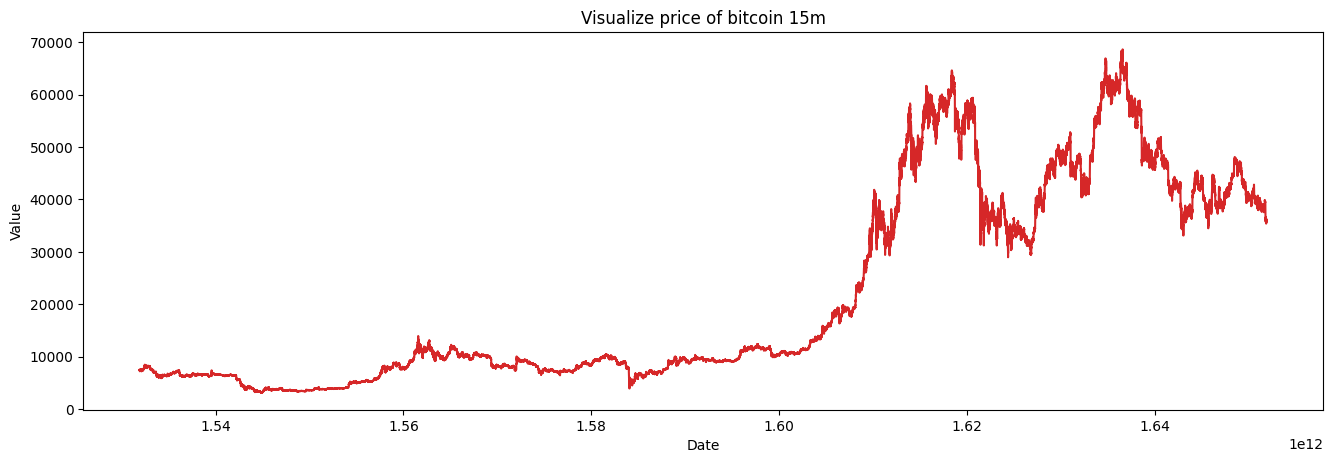

In [49]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    return

plot_df(df, x=df.index, y=df.Close, title='Visualize price of bitcoin 15m')    


# Decompose time series into its components

In [50]:
df.index = df['Time_UTC_Start']
df.drop(columns = ['Time_UTC_Start'], inplace = True)

In [51]:
df.index = pd.to_datetime(df.index)

In [52]:
df1 = df.asfreq('3600s')
df1.head()

,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Base_asset_volume,Taker_buy_base_asset_volume,label
Time_UTC_Start,,,,,,,,,,,
2018-07-18 10:39:00,7370.00,7404.23,7365.10,7402.13,421.446875,1.531911e+12,3.112218e+06,2210.0,244.531743,1.805624e+06,1.0
2018-07-18 11:39:00,7430.33,7433.58,7408.07,7418.00,412.557017,1.531915e+12,3.061536e+06,2352.0,231.403556,1.717226e+06,0.0
2018-07-18 12:39:00,7465.53,7467.74,7441.76,7454.01,512.810240,1.531918e+12,3.821516e+06,2573.0,247.813778,1.846443e+06,0.0
2018-07-18 13:39:00,7415.34,7450.00,7386.12,7447.66,938.712476,1.531922e+12,6.966361e+06,4054.0,403.602801,2.995127e+06,1.0
2018-07-18 14:39:00,7446.94,7460.28,7432.00,7439.88,331.939373,1.531926e+12,2.472527e+06,2355.0,169.370932,1.261665e+06,0.0


In [53]:
df1 = df1.fillna(method = "ffill")

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative Decomposition
result_mul = seasonal_decompose(x= df1.Close, model='multiplicative', extrapolate_trend='freq')
# Additive Decomposition
result_add = seasonal_decompose(x= df1.Close, model='additive', extrapolate_trend='freq')

# Visualize 

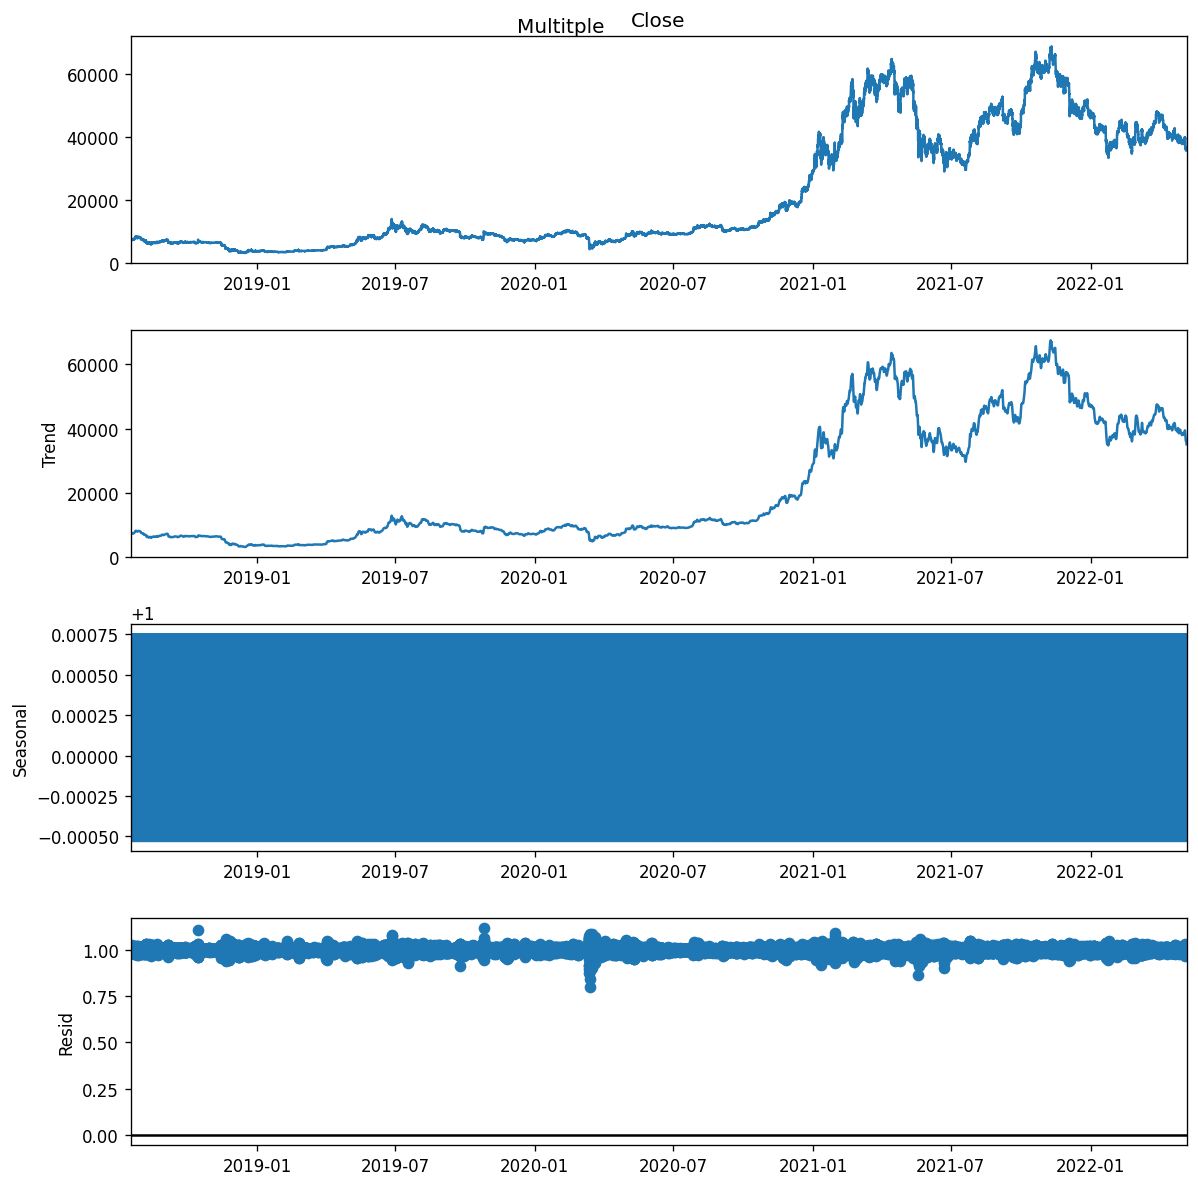

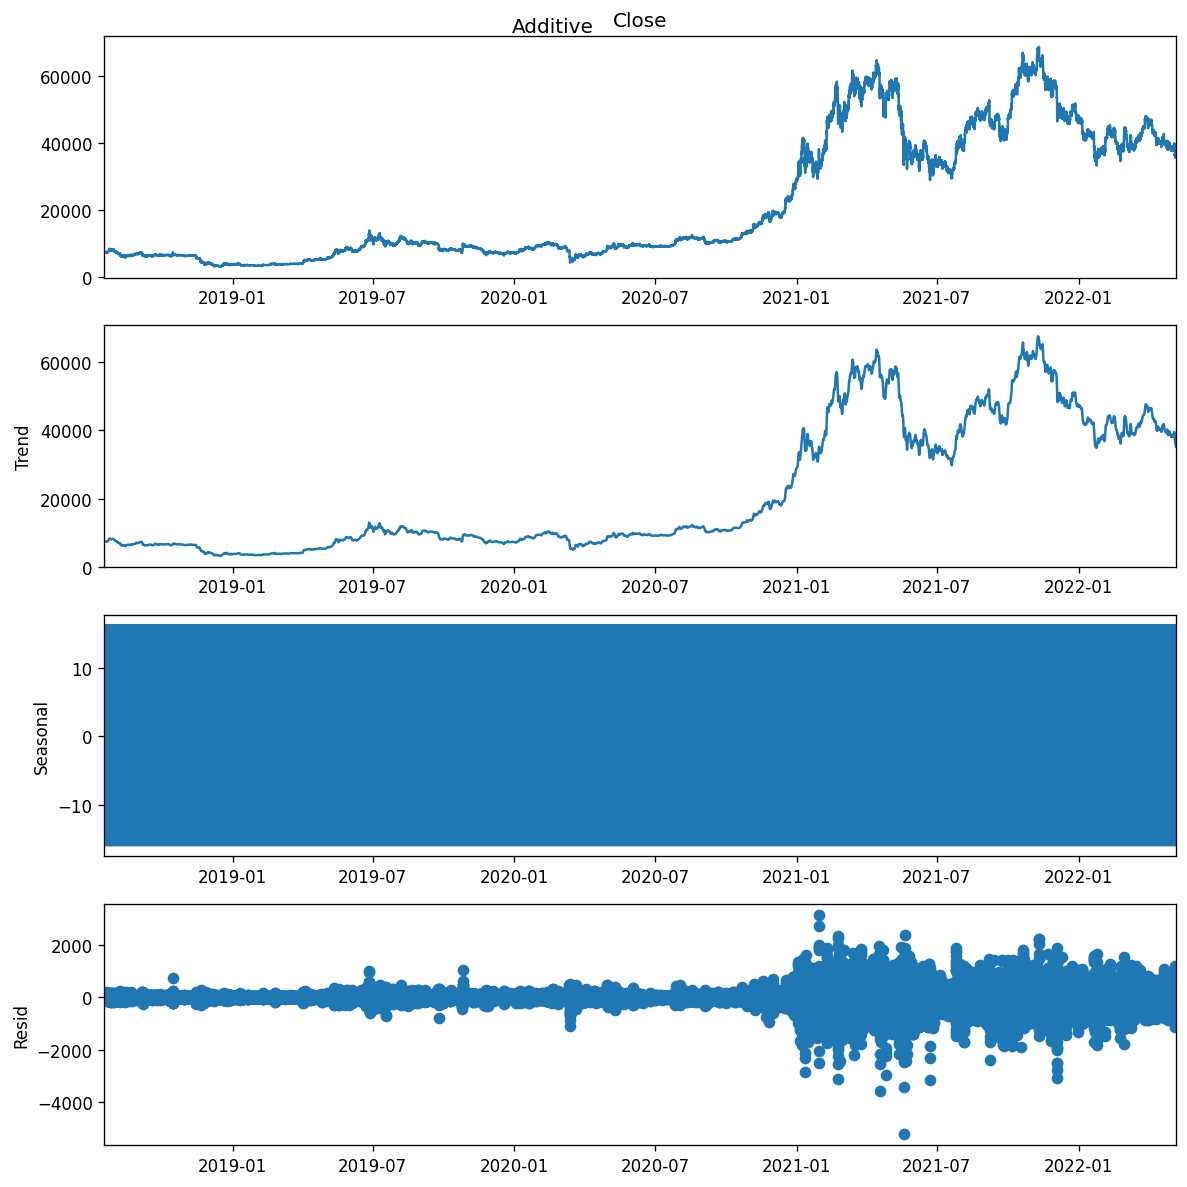

In [55]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle("Multitple", horizontalalignment = 'right', verticalalignment = 'top')
result_add.plot().suptitle("Additive", horizontalalignment = 'right', verticalalignment = 'top')
plt.show()

### As we can see that the residual in the additive decomposition much more randomly, so additive decomposition should be preferred for this particular series

In [56]:
result_add.seasonal
result_add.trend
result_add.resid

Time_UTC_Start
2018-07-18 10:39:00     83.025569
2018-07-18 11:39:00     99.797095
2018-07-18 12:39:00    128.370237
2018-07-18 13:39:00     98.953065
2018-07-18 14:39:00    103.199939
                          ...    
2022-05-07 03:39:00    546.206788
2022-05-07 04:39:00    528.677887
2022-05-07 05:39:00    617.238665
2022-05-07 06:39:00    600.311560
2022-05-07 07:39:00    805.353243
Freq: 3600S, Name: resid, Length: 33334, dtype: float64

In [57]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)

In [58]:
df_reconstructed.head()

,seasonal,trend,resid,Close
Time_UTC_Start,,,,
2018-07-18 10:39:00,0.999558,7323.589538,1.011171,7402.13
2018-07-18 11:39:00,0.999472,7326.549978,1.013017,7418.00
2018-07-18 12:39:00,0.999623,7329.510418,1.017369,7454.01
2018-07-18 13:39:00,1.000228,7332.470858,1.015478,7447.66
2018-07-18 14:39:00,0.999801,7335.431298,1.014441,7439.88


# ARIMA model

In [59]:
data = df['Close']
data

Time_UTC_Start
2018-07-18 10:39:00     7402.13
2018-07-18 10:54:00     7398.00
2018-07-18 11:09:00     7401.99
2018-07-18 11:24:00     7430.33
2018-07-18 11:39:00     7418.00
                         ...   
2022-05-07 06:39:00    35795.55
2022-05-07 06:54:00    35812.80
2022-05-07 07:09:00    35867.66
2022-05-07 07:24:00    35902.74
2022-05-07 07:39:00    35951.69
Name: Close, Length: 133333, dtype: float64

# Find d value

In [60]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [61]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.113658
p-value: 0.709595


In [62]:
from pmdarima.arima.utils import ndiffs
print("The optimal value for d is:" ,ndiffs(data, test='kpss'))

The optimal value for d is: 1


# Find the order of the MA term (q)

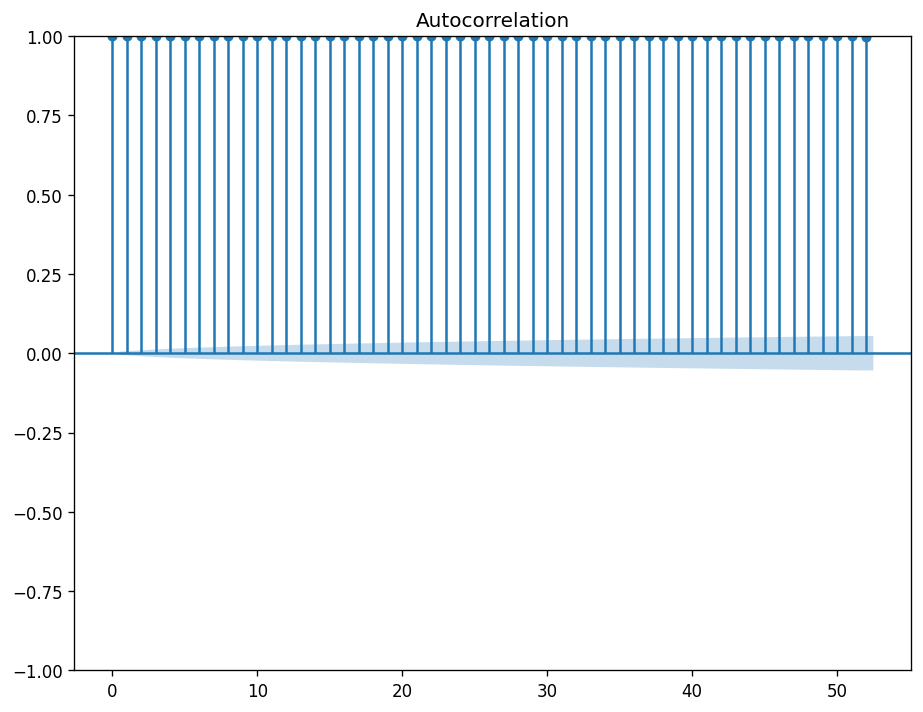

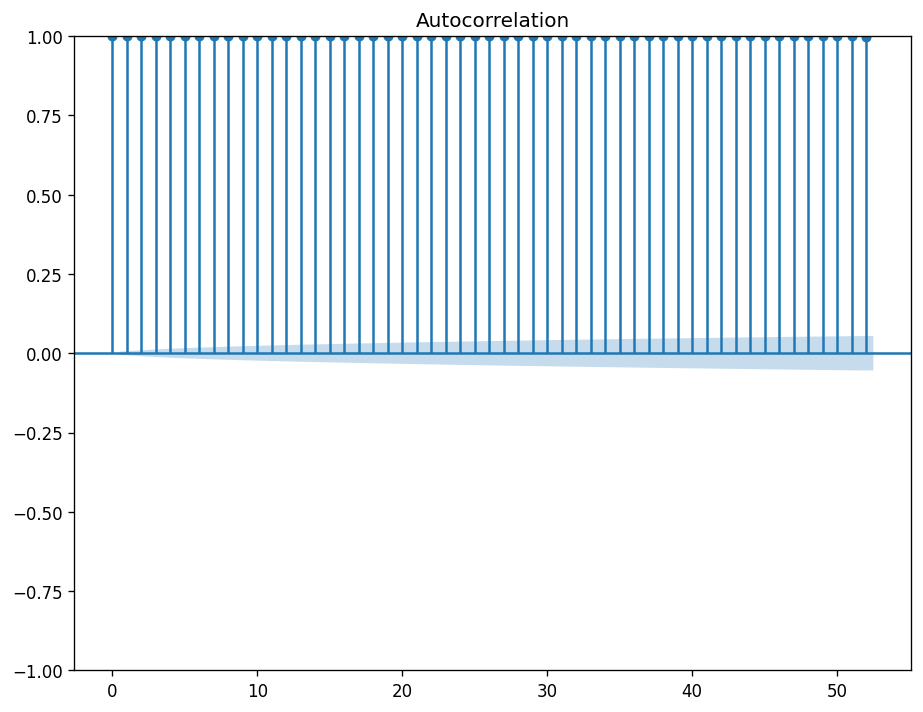

In [63]:
plot_acf(data)

# Find the order of the AR term (p)

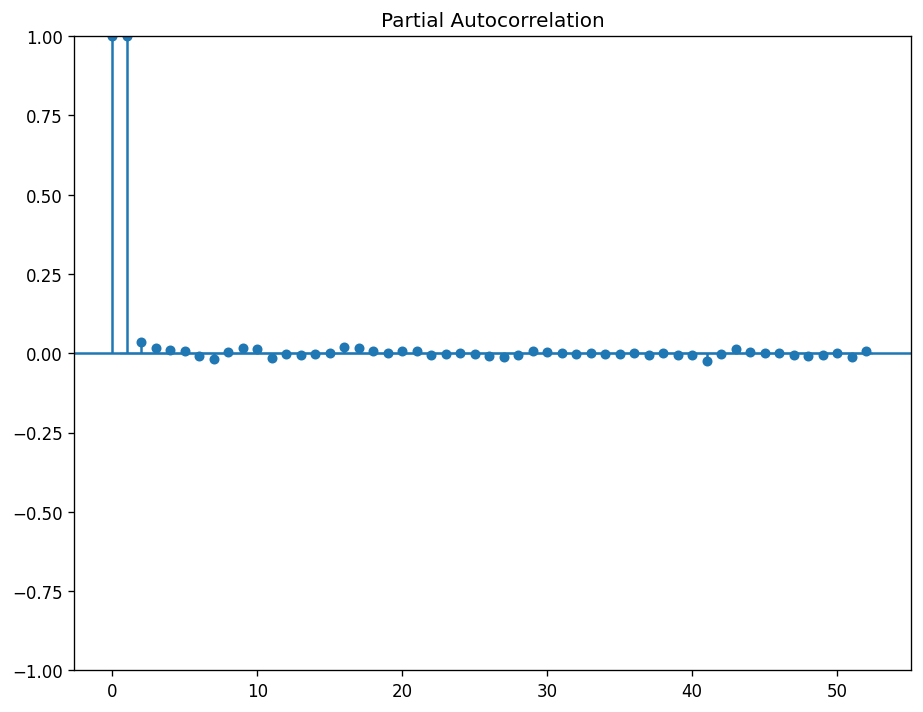

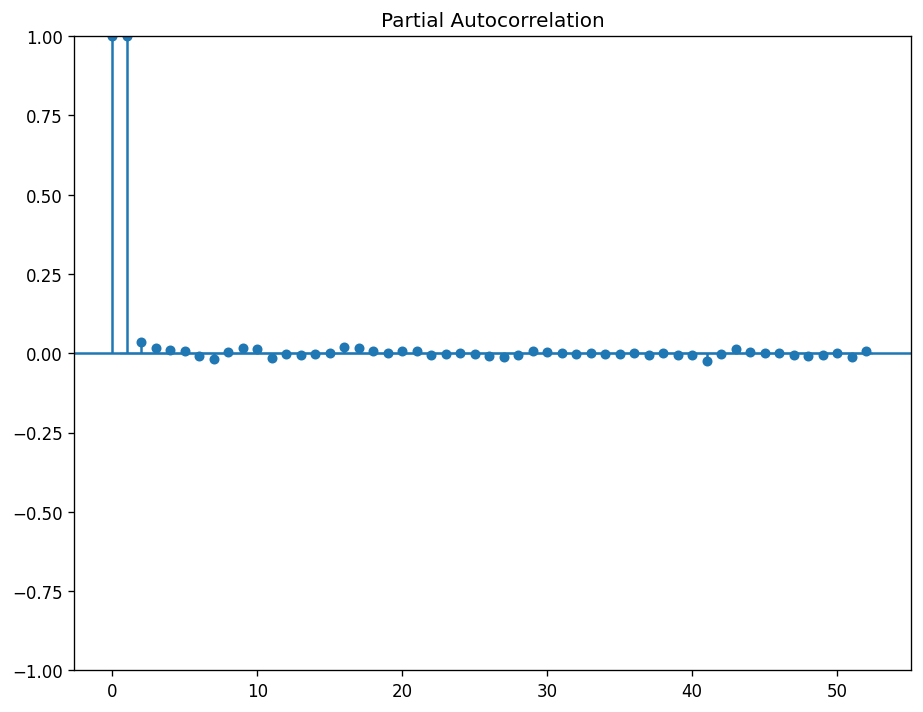

In [64]:
plot_pacf(data)

# ARIMA model

In [22]:
s = data.shape[0]
train = data[:int(s*0.8)]
test = data[int(s * 0.8):]

In [39]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(6,1,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Nguyen The Minh Duc\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nguyen The Minh Duc\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nguyen The Minh Duc\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:               106666
Model:                 ARIMA(6, 1, 2)   Log Likelihood             -649755.173
Date:                Wed, 01 Jun 2022   AIC                        1299528.346
Time:                        19:46:15   BIC                        1299614.543
Sample:                             0   HQIC                       1299554.429
                             - 106666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1707      0.025      6.827      0.000       0.122       0.220
ar.L2         -0.5308      0.021    -24.876      0.000      -0.573      -0.489
ar.L3         -0.0145      0.001    -11.081      0.0

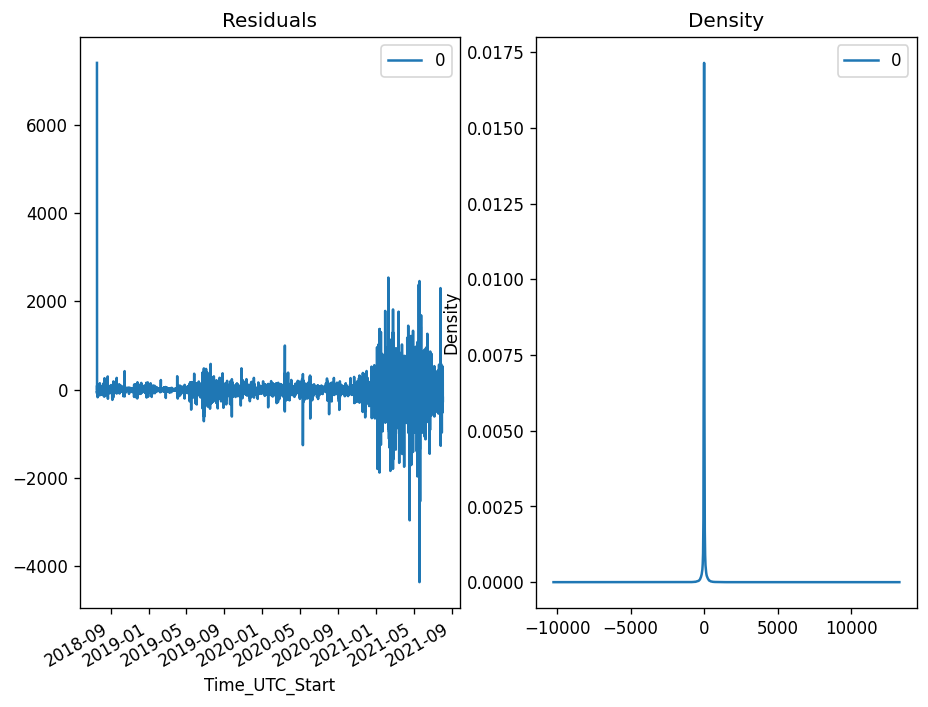

In [65]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

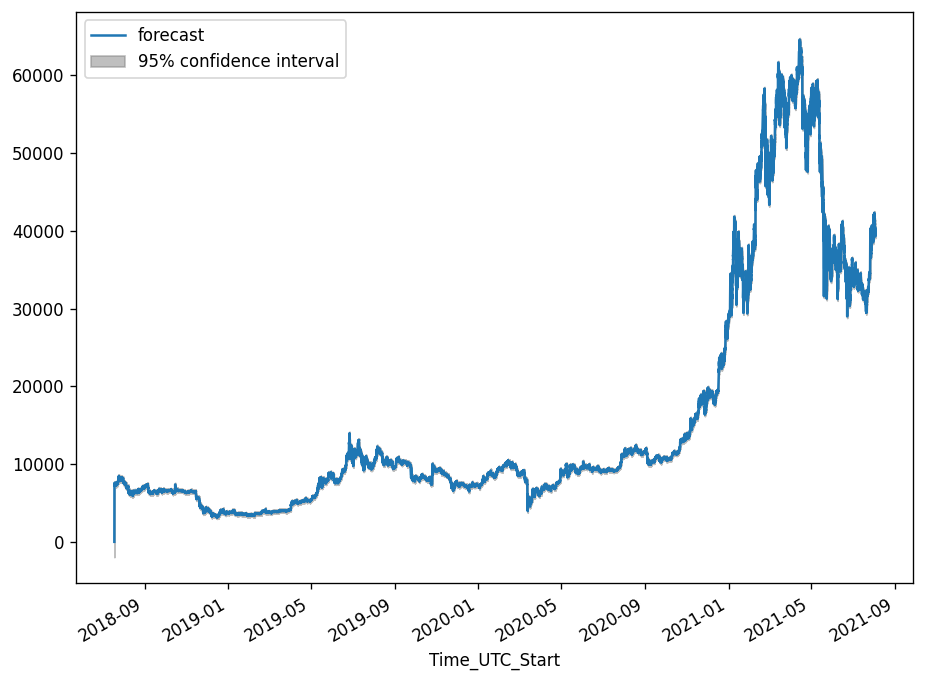

In [66]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit)
plt.show()

In [79]:
fc = model_fit.forecast(test.shape[0], alpha=0.05)  # 95% conf


In [68]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


{'mape': 0.15667264919842178,
 'me': -7856.009509455537,
 'mae': 8253.822646124489,
 'mpe': -0.14585973218634962,
 'rmse': 11061.709341415804,
 'acf1': nan,
 'corr': -0.006051386124966707,
 'minmax': 0.1563415995742995}

M lấy cái array predict nhân vs array label xong >=0 thì nhân vs 1
<br>
Là ra qays


In [92]:
pred = model_fit.predict()
score = pred - pred.shift(1)

In [93]:
test = 0 
for x in range(len(score) ):
    if data.to_list()[x]*score.to_list()[x] >= 0:
        test += 1

In [94]:
test / len(score)

0.5063844149025931

# Auto ARIMA Forecast

In [98]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [99]:
model = pm.auto_arima(data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1656898.277, Time=6.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1657048.740, Time=1.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1656929.273, Time=2.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1656925.990, Time=4.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1657047.158, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1656899.436, Time=48.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1656900.163, Time=14.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1656905.346, Time=8.92 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1656907.533, Time=3.76 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1656901.629, Time=35.74 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1656896.349, Time=2.92 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1656924.435, Time=1.95 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1656927.717, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1656904.159, Ti

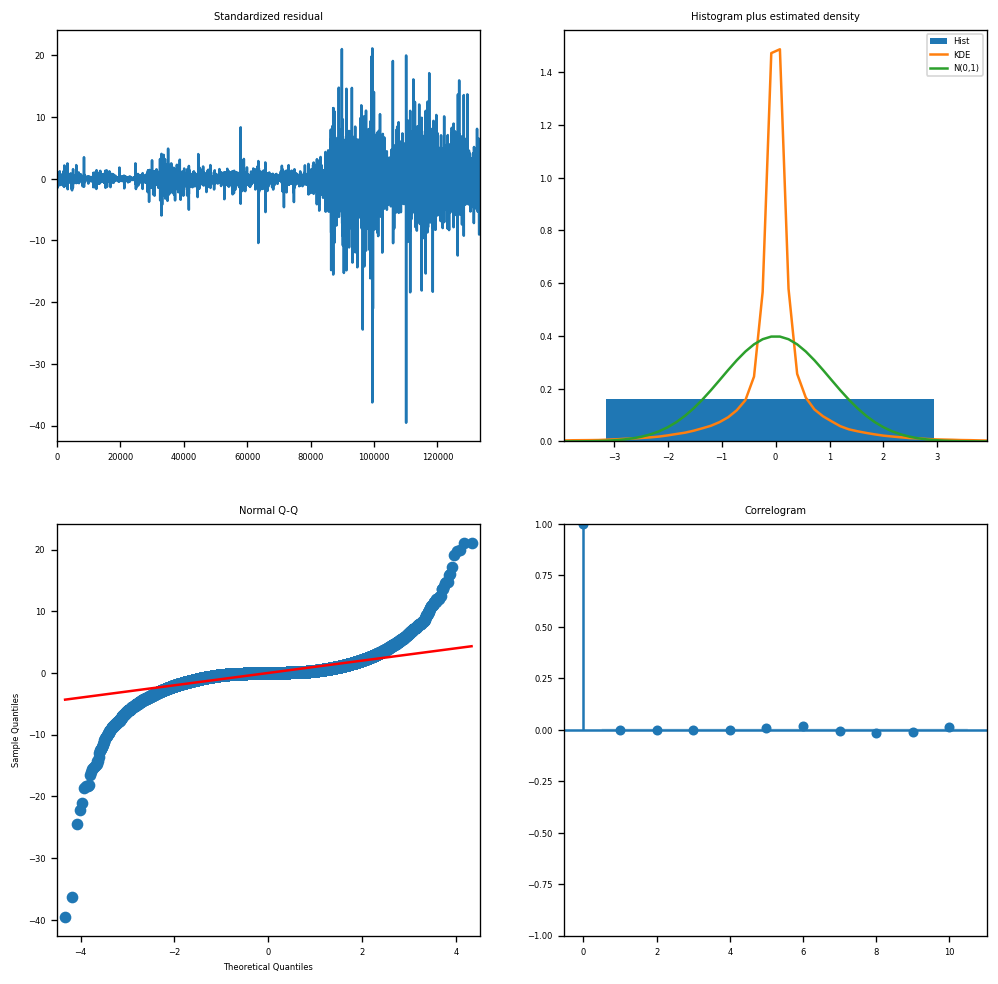

In [101]:
model.plot_diagnostics(figsize=(10,10))
plt.rcParams.update({'font.size':5})
plt.show()